In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


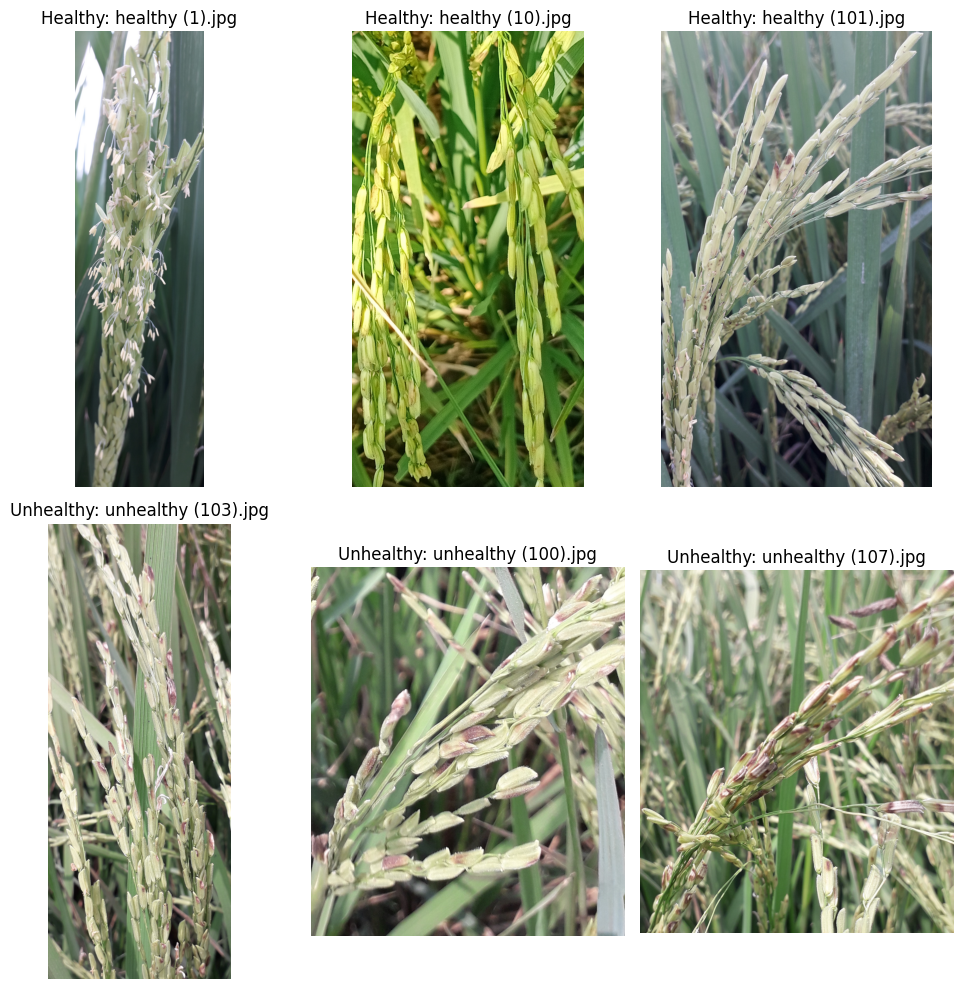

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
# Ploting some healthy and unhealthy images

# Directory containing healthy and unhealthy images
healthy_images_path = '/content/drive/MyDrive/Rice Seed Dataset/Healthy_Images'
unhealthy_images_path = '/content/drive/MyDrive/Rice Seed Dataset/Unhealthy_Images'

# List some image files in the directories
healthy_image_files = os.listdir(healthy_images_path)[:3]  # Adjust the number based on your preference
unhealthy_image_files = os.listdir(unhealthy_images_path)[:3]  # Adjust the number based on your preference

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(10, 10))

# Display healthy images
for i, filename in enumerate(healthy_image_files):
    image_path = os.path.join(healthy_images_path, filename)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axs[0, i].imshow(image_rgb)
    axs[0, i].axis('off')
    axs[0, i].set_title("Healthy: " + filename)

# Display unhealthy images
for i, filename in enumerate(unhealthy_image_files):
    image_path = os.path.join(unhealthy_images_path, filename)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axs[1, i].imshow(image_rgb)
    axs[1, i].axis('off')
    axs[1, i].set_title("Unhealthy: " + filename)

plt.tight_layout()
plt.show()

In [3]:
import os
import numpy as np
from keras.preprocessing import image
from sklearn.model_selection import train_test_split

# Define the target input size
target_size = (224, 224)

# List all image files in the healthy images directory
healthy_image_files = os.listdir(healthy_images_path)
# List all image files in the unhealthy images directory
unhealthy_image_files = os.listdir(unhealthy_images_path)

# Placeholder labels (replace with your actual labels)
healthy_labels = [0] * len(healthy_image_files)  # 0 represents healthy
unhealthy_labels = [1] * len(unhealthy_image_files)  # 1 represents unhealthy

# Combine healthy and unhealthy data
all_images = []
all_labels = []
all_images.extend(healthy_image_files)
all_images.extend(unhealthy_image_files)
all_labels.extend(healthy_labels)
all_labels.extend(unhealthy_labels)

# Shuffle the data
data = list(zip(all_images, all_labels))
np.random.shuffle(data)
all_images, all_labels = zip(*data)

# Convert to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)


In [4]:
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input

# Initialize empty lists to store preprocessed images
preprocessed_images = []

# Iterate over all image files
for filename, label in zip(all_images, all_labels):
    # Choose the appropriate path based on the label
    if label == 0:
        img_path = os.path.join(healthy_images_path, filename)
    else:
        img_path = os.path.join(unhealthy_images_path, filename)

    # Load image
    img = image.load_img(img_path, target_size=target_size)

    # Convert image to NumPy array
    img_array = image.img_to_array(img)

    # Expand dimensions to match the input shape expected by ResNet
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the input according to ResNet requirements
    img_preprocessed = preprocess_input(img_array)

    # Append the preprocessed image to the list
    preprocessed_images.append(img_preprocessed)

# Concatenate the preprocessed images along the batch axis
X = np.concatenate(preprocessed_images, axis=0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, all_labels, test_size=0.2, random_state=42)

# Print the shape of the resulting train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", len(y_train))
print("y_test shape:", len(y_test))


X_train shape: (805, 224, 224, 3)
X_test shape: (202, 224, 224, 3)
y_train shape: 805
y_test shape: 202


In [5]:
from keras.preprocessing.image import ImageDataGenerator

def simple_preprocess_input(img):
    # Normalize pixel values to be between 0 and 1
    return img / 255.0


datagen = ImageDataGenerator(
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=simple_preprocess_input
)

datagen.fit(X_train)

augmented_generator = datagen.flow(X_train, y_train, batch_size=32)


In [6]:
# Generate a batch of augmented images and labels
augmented_batch = next(augmented_generator)

# Extract the augmented images from the batch
augmented_images = augmented_batch[0]

# Print the shape of the augmented images
print("Shape of augmented images:", augmented_images.shape)


Shape of augmented images: (32, 224, 224, 3)


In [7]:
from keras.layers import Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

# Create a Sequential model
model = Sequential()

# Convolutional layers with dropout and regularization
model.add(Conv2D(512, (2, 2), activation='relu', input_shape=(224, 224, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))  # Add dropout

model.add(Conv2D(256, (2, 2), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # Add dropout

model.add(Conv2D(128, (2, 2), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # Add dropout


model.add(Conv2D(64, (2, 2), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # Add dropout

model.add(Conv2D(32, (2, 2), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # Add dropout

# Flatten layer
model.add(Flatten())

# Dense layers with dropout and regularization
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.25))  # Add dropout before the output layer

# Output layer
model.add(Dense(1, activation='sigmoid'))

opt = Adam(learning_rate=0.0005)

# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint('RiceHealthModel.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# List of callbacks to apply during training
callbacks_list = [checkpoint]

# Display the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 512)     6656      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 512)     0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 512)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 256)     524544    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 256)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 256)       0

In [9]:
epochs = 100

# Set the batch size
batch_size = 32

# Fit the model with training data and validate with validation data
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=callbacks_list
)


Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 13.2794 - accuracy: 0.5280
Epoch 1: val_accuracy improved from -inf to 0.49010, saving model to RiceHealthModel.h5
26/26 [==============================] - 50s 2s/step - loss: 13.2794 - accuracy: 0.5280 - val_loss: 7.9119 - val_accuracy: 0.4901
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - ETA: 0s - loss: 8.2823 - accuracy: 0.5466
Epoch 2: val_accuracy improved from 0.49010 to 0.56931, saving model to RiceHealthModel.h5
26/26 [==============================] - 37s 1s/step - loss: 8.2823 - accuracy: 0.5466 - val_loss: 7.5135 - val_accuracy: 0.5693
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 7.5569 - accuracy: 0.5466
Epoch 3: val_accuracy did not improve from 0.56931
26/26 [==============================] - 37s 1s/step - loss: 7.5569 - accuracy: 0.5466 - val_loss: 7.2280 - val_accuracy: 0.4950
Epoch 4/100
26/26 [==============================] - ETA: 0s - loss: 7.1673 - accuracy: 0.5702
Epoch 4: val_accuracy improved from 0.56931 to 0.57921, saving model to RiceHealthModel.h5
26/26 [==============================] - 37s 1s/step - loss: 7.1673 - accuracy: 0.5702 - val_loss: 6.9462 - val_accuracy: 0.5792
Epoch 5/100
26/26 [==============================] - ETA: 0s - loss: 6.8690 - accuracy: 0.5602
Epoch 5: val

In [12]:
from keras.models import load_model
import tensorflow as tf


# Load the model from the checkpoint file
loaded_model = load_model('RiceHealthModel.h5')

# Assuming you have X_test and y_test defined
# Evaluate the model on the test set
test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

7/7 [==============================] - 1s 134ms/step - loss: 1.8252 - accuracy: 0.8960
Test Loss: 1.8251969814300537
Test Accuracy: 0.896039605140686


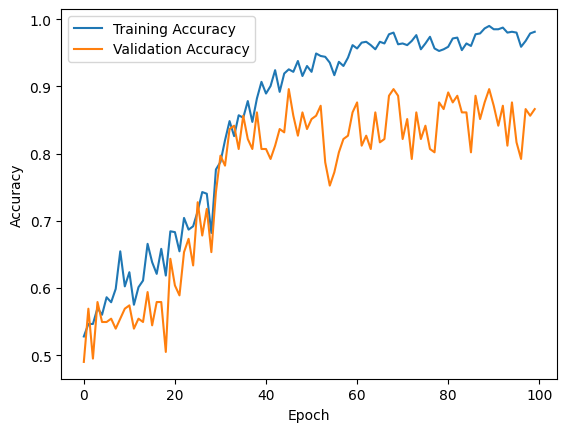

In [13]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

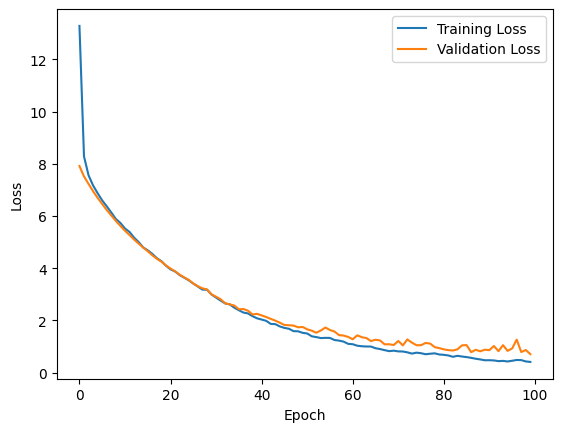

In [19]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import confusion_matrix

y_pred = loaded_model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Adjust the threshold if needed

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

7/7 [==============================] - 1s 162ms/step
Confusion Matrix:
[[92 16]
 [ 5 89]]


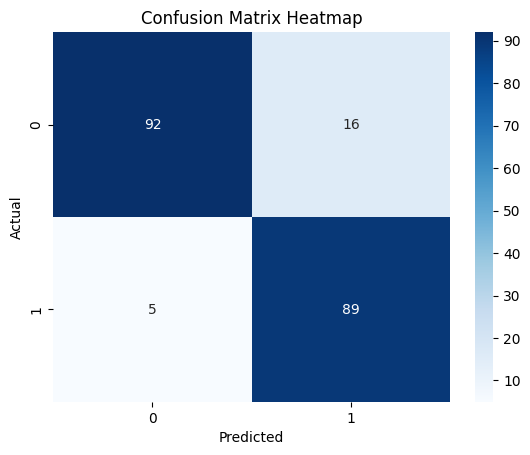

In [16]:
import seaborn as sns

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels and title
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")

# Show the plot
plt.show()

In [18]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_test, y_pred_classes)

# Print the classification report
print(report)


              precision    recall  f1-score   support

           0       0.95      0.85      0.90       108
           1       0.85      0.95      0.89        94

    accuracy                           0.90       202
   macro avg       0.90      0.90      0.90       202
weighted avg       0.90      0.90      0.90       202

